# Big Data Analysis using Apache Spark 

In [10]:
# imports 

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml import Estimator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# paths

airlines_csv = 'data\\Airlines.csv'
combined_flights = 'data\\Combined_Flights_2022.csv'

### Task 1: Understanding Dataset - Air Flight Status 


In [12]:
# initalizing the spark session 

spark = SparkSession.builder \
    .appName("Flight_Data_Analysis") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.network.timeout", "800s") \
    .getOrCreate()
    
print("Spark Session for Data Analysis Started")

Spark Session for Data Analysis Started


Reading The Dataset

In [13]:
df = spark.read.csv(combined_flights, header=True, inferSchema=True)

In [14]:
# caching the dataframe for performance 

flight_data = df.cache()

In [15]:
flight_data.show(5)

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|De

In [16]:
flight_data.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |

In [17]:
# coverting the dataset to temorary SQL Table 

flight_data.createOrReplaceTempView("flights")

InDepth Analysis and Visualization

1. Total number of flights by the airline 

In [18]:
total_flights_by_airline = spark.sql("SELECT Airline, COUNT(*) AS TotalFlights FROM flights GROUP BY Airline ORDER BY TotalFlights DESC")
total_flights_by_airline.show()

+--------------------+------------+
|             Airline|TotalFlights|
+--------------------+------------+
|Southwest Airline...|      731925|
|Delta Air Lines Inc.|      512114|
|American Airlines...|      495953|
|SkyWest Airlines ...|      440807|
|United Air Lines ...|      352009|
|   Republic Airlines|      197881|
|     JetBlue Airways|      156793|
|           Envoy Air|      150758|
|   Endeavor Air Inc.|      142624|
|         Comair Inc.|      135884|
|Alaska Airlines Inc.|      129510|
|    Spirit Air Lines|      129208|
|Frontier Airlines...|       86557|
|       Allegiant Air|       73504|
|  Mesa Airlines Inc.|       71972|
|         Horizon Air|       56320|
|Capital Cargo Int...|       52827|
|Commutair Aka Cha...|       44367|
|Hawaiian Airlines...|       42212|
|Air Wisconsin Air...|       40300|
+--------------------+------------+
only showing top 20 rows



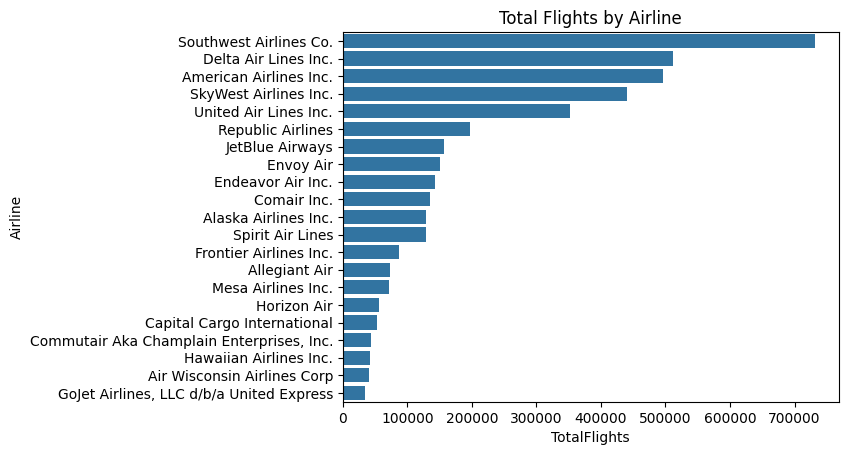

In [19]:
# Visualization

total_flights_pd = total_flights_by_airline.toPandas()
sns.barplot(x="TotalFlights", y="Airline", data=total_flights_pd)
plt.title("Total Flights by Airline")
plt.show()

2. Average Delay By Day of the week 

In [20]:
avg_delay_by_day = spark.sql("SELECT DayOfWeek, AVG(ArrDelayMinutes) AS AvgArrDelay FROM flights GROUP BY DayOfWeek ORDER BY DayOfWeek")
avg_delay_by_day.show()

+---------+------------------+
|DayOfWeek|       AvgArrDelay|
+---------+------------------+
|        1| 15.74601072509473|
|        2|11.869317071120992|
|        3|12.726657243841833|
|        4|16.852069657735345|
|        5|18.470271691679443|
|        6| 17.33519092649646|
|        7| 17.26704135159071|
+---------+------------------+



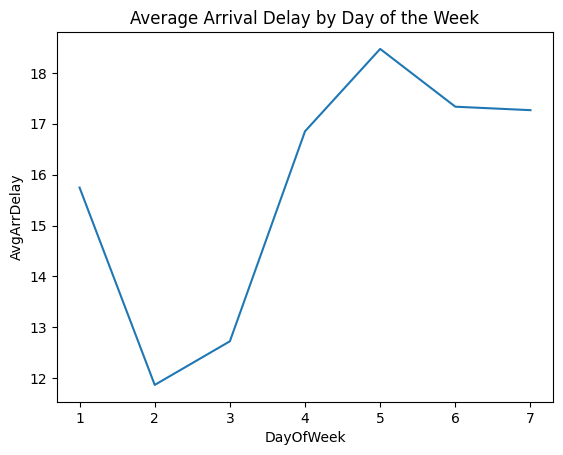

In [21]:
# Visualization

avg_delay_by_day_pd = avg_delay_by_day.toPandas()
sns.lineplot(x="DayOfWeek", y="AvgArrDelay", data=avg_delay_by_day_pd)
plt.title("Average Arrival Delay by Day of the Week")
plt.show()

### Task 2: Big Data Analysis using Spark SQL

[Performing Slightly Complex Query]

Query 1: Top 5 routes with the highest average delay

In [22]:

top_routes_delay = spark.sql("""
    SELECT Origin, Dest, AVG(ArrDelayMinutes) AS AvgArrDelay
    FROM flights
    GROUP BY Origin, Dest
    ORDER BY AvgArrDelay DESC
    LIMIT 5
""")
top_routes_delay.show()

+------+----+------------------+
|Origin|Dest|       AvgArrDelay|
+------+----+------------------+
|   DAB| DTW|             227.0|
|   EGE| PHL|             193.0|
|   SNA| BZN|             162.0|
|   EGE| LGA|143.85714285714286|
|   MSP| RIC|142.66666666666666|
+------+----+------------------+



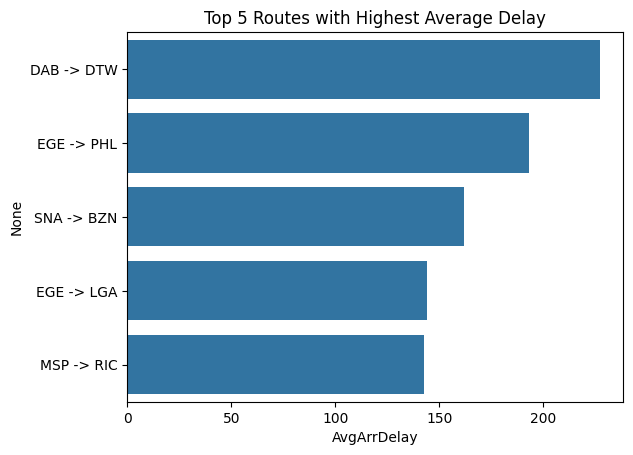

In [23]:
top_routes_pd = top_routes_delay.toPandas()
sns.barplot(x="AvgArrDelay", y=top_routes_pd.apply(lambda x: f"{x['Origin']} -> {x['Dest']}", axis=1), data=top_routes_pd)
plt.title("Top 5 Routes with Highest Average Delay")
plt.show()

Query 2: Percentage of Flights Cancelled by Airline

In [24]:
cancelled_flights = spark.sql("""
    SELECT Airline, (SUM(CASE WHEN Cancelled = true THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS CancelledPercentage
    FROM flights
    GROUP BY Airline
    ORDER BY CancelledPercentage DESC
""")
cancelled_flights.show()

+--------------------+-------------------+
|             Airline|CancelledPercentage|
+--------------------+-------------------+
|GoJet Airlines, L...|   6.96117035035783|
|   Republic Airlines|  5.779230951935759|
|     JetBlue Airways|  4.866926457176022|
|  Mesa Airlines Inc.| 4.1071527816373035|
|   Endeavor Air Inc.|  4.079958492259368|
|         Comair Inc.| 3.9379176356303907|
|       Allegiant Air|   3.93311928602525|
|American Airlines...| 3.7777773297066455|
|Air Wisconsin Air...| 3.5384615384615383|
|Commutair Aka Cha...|  3.421461897356143|
|    Spirit Air Lines| 3.2490248281840133|
|Frontier Airlines...| 2.8894254653003224|
|Alaska Airlines Inc.|  2.886263608987723|
|Capital Cargo Int...|  2.803490639256441|
|           Envoy Air|  2.580957561124451|
|Southwest Airline...| 2.4816750350104178|
|United Air Lines ...| 2.2936913544824136|
|SkyWest Airlines ...|  2.106817722949046|
|Delta Air Lines Inc.|   2.01927695786485|
|         Horizon Air| 1.7400568181818181|
+----------

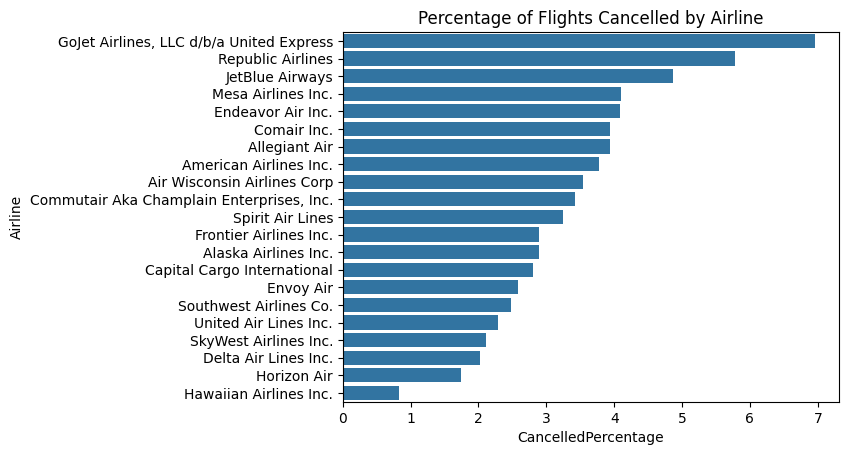

In [25]:
# Vizualization 

cancelled_flights_pd = cancelled_flights.toPandas()
sns.barplot(x="CancelledPercentage", y="Airline", data=cancelled_flights_pd)
plt.title("Percentage of Flights Cancelled by Airline")
plt.show()

Query 3: Airlines with the most significant delay contribution

In [26]:
delay_contribution = spark.sql("""
    SELECT Airline, SUM(ArrDelayMinutes) AS TotalDelay
    FROM flights
    WHERE ArrDelayMinutes IS NOT NULL
    GROUP BY Airline
    ORDER BY TotalDelay DESC
""")
delay_contribution.show()

+--------------------+----------+
|             Airline|TotalDelay|
+--------------------+----------+
|Southwest Airline...| 9875667.0|
|American Airlines...| 8499122.0|
|Delta Air Lines Inc.| 6565084.0|
|SkyWest Airlines ...| 6514262.0|
|United Air Lines ...| 5345489.0|
|     JetBlue Airways| 4214912.0|
|   Republic Airlines| 3060890.0|
|    Spirit Air Lines| 2391914.0|
|         Comair Inc.| 2293374.0|
|Frontier Airlines...| 2011856.0|
|   Endeavor Air Inc.| 1935952.0|
|       Allegiant Air| 1785963.0|
|           Envoy Air| 1603023.0|
|Alaska Airlines Inc.| 1382905.0|
|  Mesa Airlines Inc.| 1260030.0|
|Commutair Aka Cha...|  726497.0|
|GoJet Airlines, L...|  702254.0|
|Capital Cargo Int...|  667418.0|
|         Horizon Air|  529729.0|
|Air Wisconsin Air...|  517261.0|
+--------------------+----------+
only showing top 20 rows



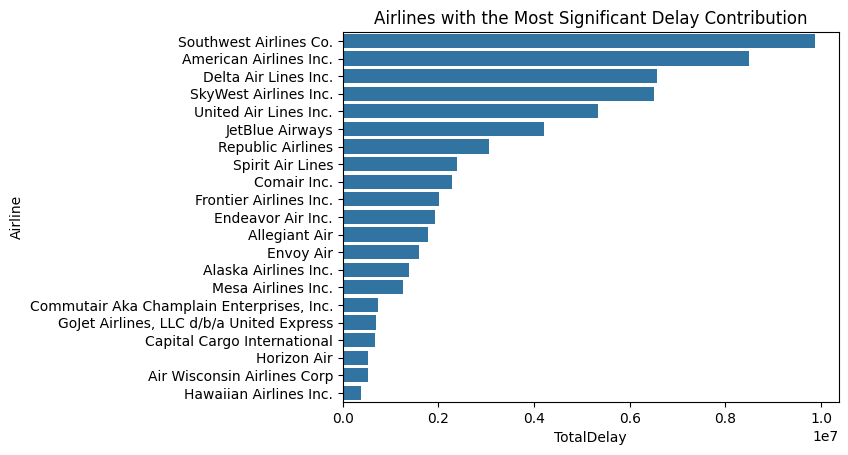

In [27]:
# Vizualization 

delay_contribution_pd = delay_contribution.toPandas()
sns.barplot(x="TotalDelay", y="Airline", data=delay_contribution_pd)
plt.title("Airlines with the Most Significant Delay Contribution")
plt.show()


In [28]:
# stopping spark 

spark.stop()

Note: since there has been repeted cases of connection error and spark session expiring creating two Spark seprate session the one above was for task 1 and task 2 and the one following will be for the ML task ... this will also allow one to adjsut the config of the SparkSession based on different needs of SQL vs ML  

### Task 3: Machine Learning using Spark MLlib


Starting Spark Session as well as loading the data as cache to a an SQL table to faster computation 

In [29]:
# initalizing SparkSession

spark = SparkSession.builder \
    .appName("Session-ML_Classification") \
    .master("local[*]") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.default.parallelism", "100") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "1024m") \
    .getOrCreate()

print("SparkSession for ML_Classification Created")

SparkSession for ML_Classification Created


In [30]:
# loading data and registering the data as a SQL Table

df = spark.read.csv(combined_flights, header=True, inferSchema=True)

flight_data = df.cache()
flight_data.createOrReplaceTempView("flights")

A: To Predict Which Flights can be Cancelled or Delayed

In [31]:
# data preparation 

# Feature Selection
ml_data = flight_data.select("Cancelled", "DepDelayMinutes", "Distance", "DayOfWeek", "Month", "Quarter")

# Drop missing values
ml_data = ml_data.na.drop()

# Convert 'Cancelled' to string if necessary
ml_data = ml_data.withColumn("Cancelled", col("Cancelled").cast("string"))

# Convert categorical to numerical using StringIndexer
label_indexer = StringIndexer(inputCol="Cancelled", outputCol="label")
ml_data = label_indexer.fit(ml_data).transform(ml_data)

# Create feature vector
assembler = VectorAssembler(
    inputCols=["DepDelayMinutes", "Distance", "DayOfWeek", "Month", "Quarter"],
    outputCol="features"
)
ml_data = assembler.transform(ml_data)

# Take 10% sample
# ml_data = ml_data.sample(fraction=0.1, seed=42)

In [32]:
# Train-Test Split
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

In [33]:
# Logistic Regression 

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
lr_pipeline = Pipeline(stages=[lr])
lr_model = lr_pipeline.fit(train_data)
lr_predictions = lr_model.transform(test_data)

In [34]:
# Random Forest Classifier (with reduced trees for memory optimization)

rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10, maxDepth=5)
rf_pipeline = Pipeline(stages=[rf])
rf_model = rf_pipeline.fit(train_data)
rf_predictions = rf_model.transform(test_data)

In [35]:
# Gradient-Boosted Trees Classifier (with reduced iterations for memory optimization)

gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=5, maxDepth=3)
gbt_pipeline = Pipeline(stages=[gbt])
gbt_model = gbt_pipeline.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

In [36]:
# Evaluate Models

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
lr_accuracy = accuracy_evaluator.evaluate(lr_predictions)
rf_accuracy = accuracy_evaluator.evaluate(rf_predictions)
gbt_accuracy = accuracy_evaluator.evaluate(gbt_predictions)

# Print Results
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Gradient-Boosted Trees Accuracy: {gbt_accuracy:.2f}")

Logistic Regression Accuracy: 1.00
Random Forest Accuracy: 1.00
Gradient-Boosted Trees Accuracy: 1.00


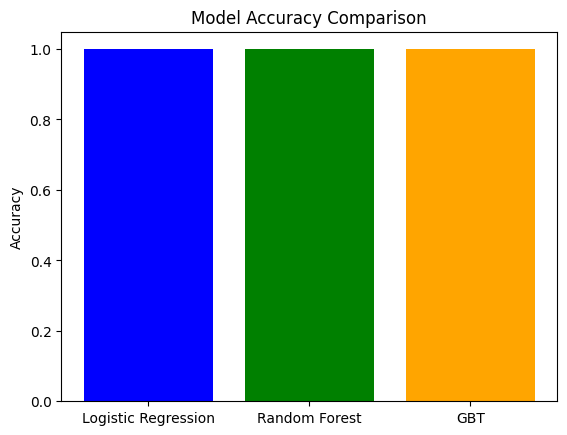

In [37]:
# Visualization

plt.bar(["Logistic Regression", "Random Forest", "GBT"], [lr_accuracy, rf_accuracy, gbt_accuracy], color=['blue', 'green', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

In [38]:
spark.stop()

Note: Due to the huge amount of time taken by the model to train SparkSession stops mid way so another instance of Spark Session creted so ML - Classification is the session that was being used so far and the next cell onwards will be using ML_Regression session.

In [39]:
# Creating the SparkSession for Regression  

spark = SparkSession.builder \
    .appName("Session-ML_Regression") \
    .master("local[*]") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.default.parallelism", "100") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "1024m") \
    .getOrCreate()

print("SparkSession for ML_Regression Created")

SparkSession for ML_Regression Created


In [40]:
# reloading of data before actual data preparation and model development 

df = spark.read.csv(combined_flights, header=True, inferSchema=True)

flight_data = df.cache()
flight_data.createOrReplaceTempView("flights")


B: To predict the delayed time of flights

In [41]:
# data preparation 

# Feature Engineering for Regression
regression_data = flight_data.select("DepDelayMinutes", "Distance", "DayOfWeek", "Month", "Quarter", "ArrDelayMinutes")
regression_data = regression_data.na.drop()

assembler = VectorAssembler(inputCols=["DepDelayMinutes", "Distance", "DayOfWeek", "Month", "Quarter"], outputCol="features")
regression_data = assembler.transform(regression_data).withColumnRenamed("ArrDelayMinutes", "label")

# Feature Scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
regression_data = scaler.fit(regression_data).transform(regression_data)

In [42]:
# Train-Test Split

train_data, test_data = regression_data.randomSplit([0.8, 0.2], seed=42)

In [43]:
# Linear Regression

lr = LinearRegression(featuresCol="scaledFeatures", labelCol="label")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

In [44]:
# Decision Tree Regressior

dtr = DecisionTreeRegressor(featuresCol="scaledFeatures", labelCol="label")
dtr_model = dtr.fit(train_data)
dtr_predictions = dtr_model.transform(test_data)

In [45]:
# GBT Regressor

gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol="label")

param_grid = ParamGridBuilder().addGrid(gbt.maxDepth, [3, 5]).addGrid(gbt.maxIter, [10, 20]).build()
crossval = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid, evaluator=RegressionEvaluator(labelCol="label"), numFolds=3)
gbt_model = crossval.fit(train_data).bestModel

gbt_predictions = gbt_model.transform(test_data)

In [46]:
# Evaluate Models

evaluator = RegressionEvaluator(labelCol="label", metricName="rmse")

lr_rmse = evaluator.evaluate(lr_predictions)
dtr_rmse = evaluator.evaluate(dtr_predictions)
gbt_rmse = evaluator.evaluate(gbt_predictions)

print(f"Linear Regression RMSE: {lr_rmse:.2f}")
print(f"Decision Tree RMSE: {dtr_rmse:.2f}")
print(f"GBT RMSE: {gbt_rmse:.2f}")



Linear Regression RMSE: 10.28
Decision Tree RMSE: 33.26
GBT RMSE: 32.80


<function matplotlib.pyplot.show(close=None, block=None)>

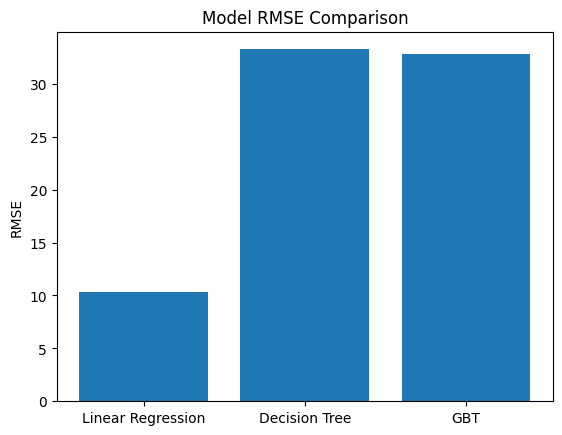

In [47]:
# Visualization

plt.bar(["Linear Regression", "Decision Tree", "GBT"], [lr_rmse, dtr_rmse, gbt_rmse])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.show

In [48]:
# Stopping Spark Session 

spark.stop()